In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout,Activation
from tensorflow.python.keras import metrics
from sklearn.preprocessing import StandardScaler
from tensorflow.python import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score ## F1 Score 구하기
from sklearn.metrics import precision_recall_fscore_support as sk

# 파일읽기

In [2]:
df=pd.read_excel('../optimal_data3_1/'+'Continous_2weeks_2day_1term.xlsx')

In [3]:
df

,0,1,2,3,4,5,6,7,8
0,#AAGQKY,45.15,20.612673,72.0,0.0,0.0,0.0,148.0,0
1,#AAGQKY,45.15,20.612673,72.0,0.0,0.0,0.0,148.0,0
2,#AAGQKY,45.15,20.612673,72.0,0.0,0.0,0.0,148.0,0
3,#AAGQKY,45.15,20.612673,72.0,0.0,0.0,0.0,148.0,0
4,#AAGQKY,45.15,20.612673,72.0,0.0,0.0,0.0,148.0,0
...,...,...,...,...,...,...,...,...,...
58820,#ZZLSSL,68.00,29.048656,0.0,0.0,0.0,0.0,153.0,0
58821,#ZZLSSL,68.00,29.048656,0.0,0.0,0.0,0.0,153.0,0
58822,#ZZLSSL,68.00,29.048656,0.0,0.0,0.0,0.0,153.0,0
58823,#ZZLSSL,68.00,29.048656,0.0,0.0,0.0,0.0,153.0,0


# 데이터를 필요한 부분으로 X, Y 나눠 읽어오기

In [4]:
X=df.iloc[:,[1,3,4,5,6,7]]
y=df.iloc[:,-1]

scaler = StandardScaler()
X = scaler.fit_transform(X)
X=pd.DataFrame(X)

#결과 넣을 배열
Result=[[0 for j in range(4)] for i in range(10)]
pred_list=[]
LossResult=[[0 for j in range(100)] for i in range(10)]
AccuracyResult=[[0 for j in range(100)] for i in range(10)]

In [5]:
#한 사람당 데이터 수
Count_1=int(181*0.1)
#한 사람당 데이터 수
Count_2=181

X_test=pd.DataFrame()
X_train=pd.DataFrame()
y_test=pd.DataFrame()
y_train=pd.DataFrame()
empty=pd.DataFrame()

#결과 넣을 배열
Result=[[0 for j in range(4)] for i in range(10)]

# 모델

## Deep Neural Network

## Input Feature : 6

## Hidden Layer : 128 - 256 - 128

## optimizer : adam, loss : categorical_crossentropy

In [6]:
for k in range(10):
    globals()["model{}".format(k)] = keras.Sequential([
        keras.layers.Flatten(input_shape=(6,)),
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dense(256, activation=tf.nn.relu),
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dense(3, activation=tf.nn.softmax),
    ])
    
    if k==0:
        model0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                      optimizer='adam',
                      metrics=['accuracy'])
    if k==1:
        model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                      optimizer='adam',
                      metrics=['accuracy'])
        
    if k==2:
        model2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                      optimizer='adam',
                      metrics=['accuracy'])
    if k==3:
        model3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                      optimizer='adam',
                      metrics=['accuracy'])
    if k==4:
        model4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                      optimizer='adam',
                      metrics=['accuracy'])
    if k==5:
        model5.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                      optimizer='adam',
                      metrics=['accuracy'])
    if k==6:
        model6.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                      optimizer='adam',
                      metrics=['accuracy'])
    if k==7:
        model7.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                      optimizer='adam',
                      metrics=['accuracy'])
    if k==8:
        model8.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                      optimizer='adam',
                      metrics=['accuracy'])
    if k==9:
        model9.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                      optimizer='adam',
                      metrics=['accuracy'])
    

Epoch 1/100
8398/8398 [==============================] - 28s 3ms/step - loss: 0.8073 - accuracy: 0.6176 - val_loss: 1.3892 - val_accuracy: 0.4460
Epoch 2/100
8398/8398 [==============================] - 30s 4ms/step - loss: 0.5927 - accuracy: 0.7474 - val_loss: 1.5373 - val_accuracy: 0.4679
Epoch 3/100
8398/8398 [==============================] - 31s 4ms/step - loss: 0.5008 - accuracy: 0.7934 - val_loss: 1.9851 - val_accuracy: 0.4475
Epoch 4/100
8398/8398 [==============================] - 32s 4ms/step - loss: 0.4491 - accuracy: 0.8191 - val_loss: 2.1441 - val_accuracy: 0.4571
Epoch 5/100
8398/8398 [==============================] - 30s 4ms/step - loss: 0.4158 - accuracy: 0.8337 - val_loss: 2.1417 - val_accuracy: 0.4742
Epoch 6/100
8398/8398 [==============================] - 29s 3ms/step - loss: 0.3910 - accuracy: 0.8456 - val_loss: 2.5350 - val_accuracy: 0.4542
Epoch 7/100
8398/8398 [==============================] - 31s 4ms/step - loss: 0.3699 - accuracy: 0.8541 - val_loss: 2.4920 -

Epoch 57/100
8398/8398 [==============================] - 32s 4ms/step - loss: 0.1969 - accuracy: 0.9244 - val_loss: 4.9285 - val_accuracy: 0.4414
Epoch 58/100
8398/8398 [==============================] - 32s 4ms/step - loss: 0.1959 - accuracy: 0.9241 - val_loss: 5.0509 - val_accuracy: 0.4328
Epoch 59/100
8398/8398 [==============================] - 32s 4ms/step - loss: 0.1952 - accuracy: 0.9247 - val_loss: 4.9990 - val_accuracy: 0.4349
Epoch 60/100
8398/8398 [==============================] - 31s 4ms/step - loss: 0.1939 - accuracy: 0.9246 - val_loss: 5.0045 - val_accuracy: 0.4318
Epoch 61/100
8398/8398 [==============================] - 30s 4ms/step - loss: 0.1925 - accuracy: 0.9252 - val_loss: 5.0361 - val_accuracy: 0.4480
Epoch 62/100
8398/8398 [==============================] - 28s 3ms/step - loss: 0.1922 - accuracy: 0.9261 - val_loss: 4.9768 - val_accuracy: 0.4488
Epoch 63/100
8398/8398 [==============================] - 26s 3ms/step - loss: 0.1919 - accuracy: 0.9254 - val_loss: 5

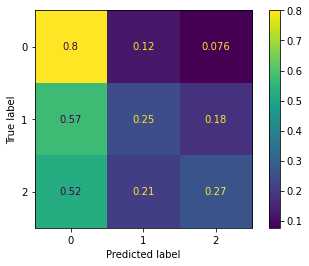

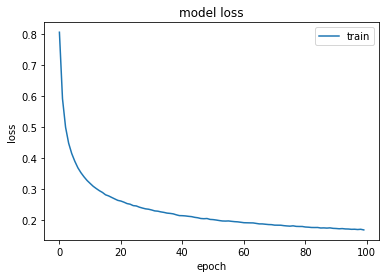

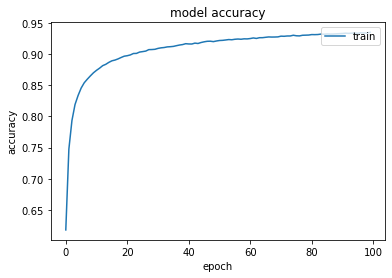

Epoch 1/100
8398/8398 [==============================] - 28s 3ms/step - loss: 0.8102 - accuracy: 0.6103 - val_loss: 0.7416 - val_accuracy: 0.6751
Epoch 2/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.5980 - accuracy: 0.7444 - val_loss: 0.6976 - val_accuracy: 0.7100
Epoch 3/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.5072 - accuracy: 0.7910 - val_loss: 0.6088 - val_accuracy: 0.7506
Epoch 4/100
8398/8398 [==============================] - 28s 3ms/step - loss: 0.4535 - accuracy: 0.8140 - val_loss: 0.6139 - val_accuracy: 0.7566
Epoch 5/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.4189 - accuracy: 0.8313 - val_loss: 0.5778 - val_accuracy: 0.7786
Epoch 6/100
8398/8398 [==============================] - 28s 3ms/step - loss: 0.3932 - accuracy: 0.8425 - val_loss: 0.6347 - val_accuracy: 0.7594
Epoch 7/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.3735 - accuracy: 0.8516 - val_loss: 0.5701 -

Epoch 57/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.2012 - accuracy: 0.9216 - val_loss: 0.5834 - val_accuracy: 0.8456
Epoch 58/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.2015 - accuracy: 0.9220 - val_loss: 0.6118 - val_accuracy: 0.8419
Epoch 59/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.2009 - accuracy: 0.9222 - val_loss: 0.6510 - val_accuracy: 0.8366
Epoch 60/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1990 - accuracy: 0.9234 - val_loss: 0.5942 - val_accuracy: 0.8409
Epoch 61/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1989 - accuracy: 0.9231 - val_loss: 0.6082 - val_accuracy: 0.8373
Epoch 62/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1976 - accuracy: 0.9237 - val_loss: 0.5993 - val_accuracy: 0.8478
Epoch 63/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1973 - accuracy: 0.9247 - val_loss: 0

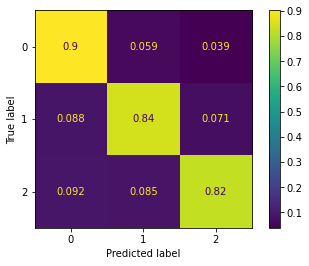

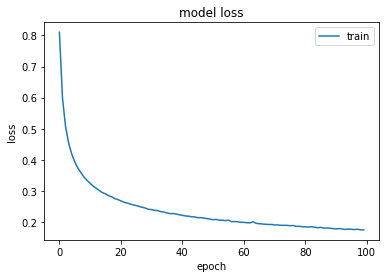

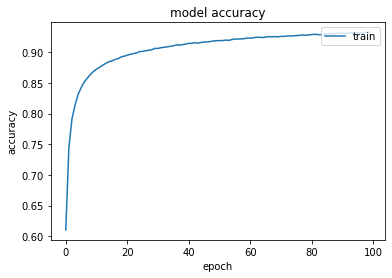

Epoch 1/100
8398/8398 [==============================] - 28s 3ms/step - loss: 0.8150 - accuracy: 0.6076 - val_loss: 0.7671 - val_accuracy: 0.6258
Epoch 2/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.6019 - accuracy: 0.7408 - val_loss: 0.6372 - val_accuracy: 0.7255
Epoch 3/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.5073 - accuracy: 0.7910 - val_loss: 0.6199 - val_accuracy: 0.7456
Epoch 4/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.4526 - accuracy: 0.8177 - val_loss: 0.6089 - val_accuracy: 0.7578
Epoch 5/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.4185 - accuracy: 0.8320 - val_loss: 0.5937 - val_accuracy: 0.7647
Epoch 6/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.3919 - accuracy: 0.8444 - val_loss: 0.5736 - val_accuracy: 0.7743
Epoch 7/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.3740 - accuracy: 0.8520 - val_loss: 0.5855 -

Epoch 57/100
8398/8398 [==============================] - 26s 3ms/step - loss: 0.2015 - accuracy: 0.9225 - val_loss: 0.6399 - val_accuracy: 0.8197
Epoch 58/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1999 - accuracy: 0.9231 - val_loss: 0.6908 - val_accuracy: 0.8151
Epoch 59/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1988 - accuracy: 0.9234 - val_loss: 0.6617 - val_accuracy: 0.8258
Epoch 60/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1987 - accuracy: 0.9237 - val_loss: 0.6789 - val_accuracy: 0.8192
Epoch 61/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1984 - accuracy: 0.9239 - val_loss: 0.7116 - val_accuracy: 0.8109
Epoch 62/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1982 - accuracy: 0.9239 - val_loss: 0.6889 - val_accuracy: 0.8189
Epoch 63/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1953 - accuracy: 0.9246 - val_loss: 0

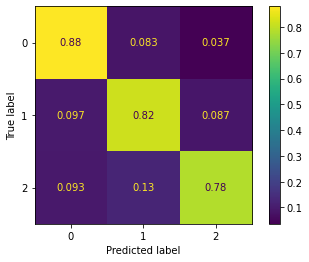

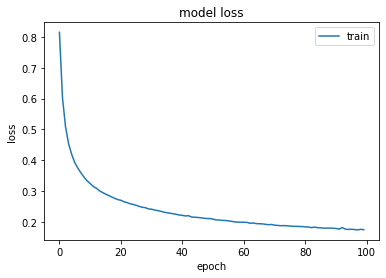

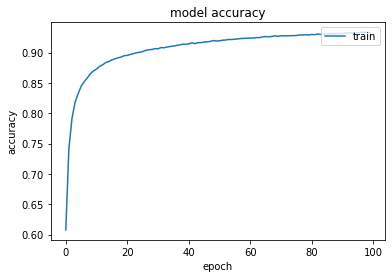

Epoch 1/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.8121 - accuracy: 0.6113 - val_loss: 0.7306 - val_accuracy: 0.6631
Epoch 2/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.5965 - accuracy: 0.7456 - val_loss: 0.6553 - val_accuracy: 0.7146
Epoch 3/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.5082 - accuracy: 0.7912 - val_loss: 0.5843 - val_accuracy: 0.7711
Epoch 4/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.4565 - accuracy: 0.8152 - val_loss: 0.5602 - val_accuracy: 0.7774
Epoch 5/100
8398/8398 [==============================] - 26s 3ms/step - loss: 0.4208 - accuracy: 0.8321 - val_loss: 0.5872 - val_accuracy: 0.7536
Epoch 6/100
8398/8398 [==============================] - 26s 3ms/step - loss: 0.3955 - accuracy: 0.8424 - val_loss: 0.5632 - val_accuracy: 0.7793
Epoch 7/100
8398/8398 [==============================] - 26s 3ms/step - loss: 0.3772 - accuracy: 0.8508 - val_loss: 0.5720 -

Epoch 57/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.2031 - accuracy: 0.9220 - val_loss: 0.7166 - val_accuracy: 0.8206
Epoch 58/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.2013 - accuracy: 0.9227 - val_loss: 0.7252 - val_accuracy: 0.8229
Epoch 59/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.2015 - accuracy: 0.9226 - val_loss: 0.7179 - val_accuracy: 0.8177
Epoch 60/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.2002 - accuracy: 0.9228 - val_loss: 0.7975 - val_accuracy: 0.8170
Epoch 61/100
8398/8398 [==============================] - 26s 3ms/step - loss: 0.1998 - accuracy: 0.9232 - val_loss: 0.7828 - val_accuracy: 0.8205
Epoch 62/100
8398/8398 [==============================] - 26s 3ms/step - loss: 0.1981 - accuracy: 0.9240 - val_loss: 0.8390 - val_accuracy: 0.8070
Epoch 63/100
8398/8398 [==============================] - 26s 3ms/step - loss: 0.1970 - accuracy: 0.9238 - val_loss: 0

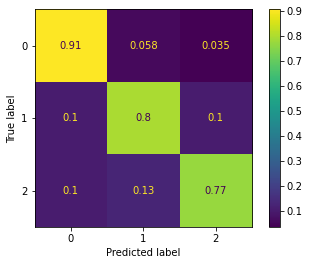

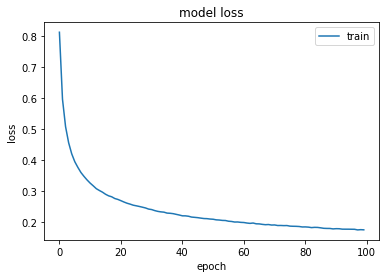

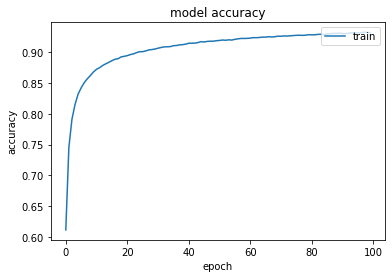

Epoch 1/100
8398/8398 [==============================] - 28s 3ms/step - loss: 0.8114 - accuracy: 0.6126 - val_loss: 0.6675 - val_accuracy: 0.7054
Epoch 2/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.5941 - accuracy: 0.7465 - val_loss: 0.5712 - val_accuracy: 0.7573
Epoch 3/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.5006 - accuracy: 0.7937 - val_loss: 0.5336 - val_accuracy: 0.7853
Epoch 4/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.4485 - accuracy: 0.8194 - val_loss: 0.5064 - val_accuracy: 0.7982
Epoch 5/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.4137 - accuracy: 0.8335 - val_loss: 0.5100 - val_accuracy: 0.7813
Epoch 6/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.3890 - accuracy: 0.8445 - val_loss: 0.4817 - val_accuracy: 0.8244
Epoch 7/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.3704 - accuracy: 0.8529 - val_loss: 0.5211 -

Epoch 57/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1996 - accuracy: 0.9229 - val_loss: 0.5419 - val_accuracy: 0.8479
Epoch 58/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.2003 - accuracy: 0.9232 - val_loss: 0.5301 - val_accuracy: 0.8555
Epoch 59/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1986 - accuracy: 0.9238 - val_loss: 0.5581 - val_accuracy: 0.8483
Epoch 60/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1977 - accuracy: 0.9236 - val_loss: 0.5601 - val_accuracy: 0.8472
Epoch 61/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1970 - accuracy: 0.9240 - val_loss: 0.4920 - val_accuracy: 0.8642
Epoch 62/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1949 - accuracy: 0.9248 - val_loss: 0.5456 - val_accuracy: 0.8497
Epoch 63/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1954 - accuracy: 0.9240 - val_loss: 0

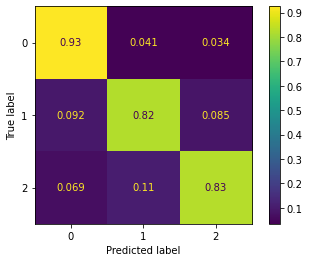

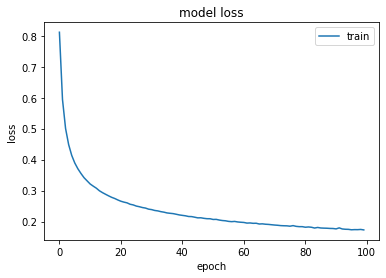

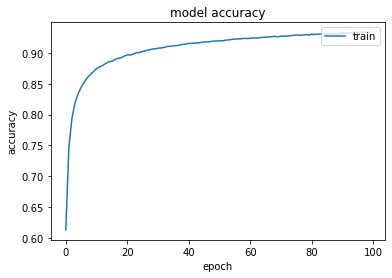

Epoch 1/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.8126 - accuracy: 0.6110 - val_loss: 0.7221 - val_accuracy: 0.6494
Epoch 2/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.5977 - accuracy: 0.7460 - val_loss: 0.6374 - val_accuracy: 0.7228
Epoch 3/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.5079 - accuracy: 0.7917 - val_loss: 0.6294 - val_accuracy: 0.7187
Epoch 4/100
8398/8398 [==============================] - 26s 3ms/step - loss: 0.4566 - accuracy: 0.8152 - val_loss: 0.6301 - val_accuracy: 0.7392
Epoch 5/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.4233 - accuracy: 0.8289 - val_loss: 0.6647 - val_accuracy: 0.7273
Epoch 6/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.3980 - accuracy: 0.8406 - val_loss: 0.6866 - val_accuracy: 0.7523
Epoch 7/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.3788 - accuracy: 0.8496 - val_loss: 0.6007 -

Epoch 57/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.2010 - accuracy: 0.9223 - val_loss: 1.0095 - val_accuracy: 0.7828
Epoch 58/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.2022 - accuracy: 0.9219 - val_loss: 0.9715 - val_accuracy: 0.7769
Epoch 59/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1996 - accuracy: 0.9230 - val_loss: 1.0519 - val_accuracy: 0.7687
Epoch 60/100
8398/8398 [==============================] - 26s 3ms/step - loss: 0.1994 - accuracy: 0.9241 - val_loss: 1.0450 - val_accuracy: 0.7853
Epoch 61/100
8398/8398 [==============================] - 26s 3ms/step - loss: 0.1979 - accuracy: 0.9247 - val_loss: 1.0947 - val_accuracy: 0.7622
Epoch 62/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1971 - accuracy: 0.9242 - val_loss: 0.9107 - val_accuracy: 0.7975
Epoch 63/100
8398/8398 [==============================] - 26s 3ms/step - loss: 0.1964 - accuracy: 0.9248 - val_loss: 1

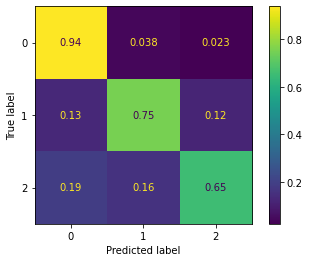

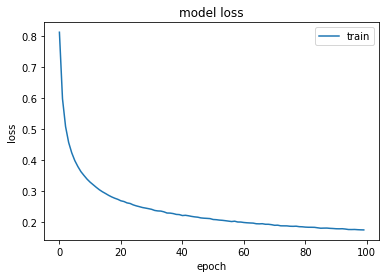

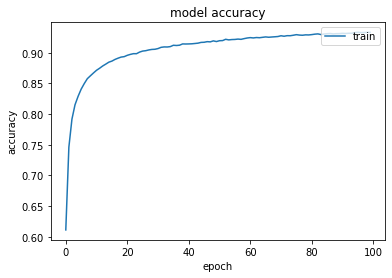

Epoch 1/100
8398/8398 [==============================] - 28s 3ms/step - loss: 0.8068 - accuracy: 0.6152 - val_loss: 0.6493 - val_accuracy: 0.7100
Epoch 2/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.5954 - accuracy: 0.7451 - val_loss: 0.5480 - val_accuracy: 0.7713
Epoch 3/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.5060 - accuracy: 0.7906 - val_loss: 0.6150 - val_accuracy: 0.7361
Epoch 4/100
8398/8398 [==============================] - 28s 3ms/step - loss: 0.4533 - accuracy: 0.8156 - val_loss: 0.5464 - val_accuracy: 0.7783
Epoch 5/100
8398/8398 [==============================] - 28s 3ms/step - loss: 0.4186 - accuracy: 0.8322 - val_loss: 0.5729 - val_accuracy: 0.7820
Epoch 6/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.3931 - accuracy: 0.8434 - val_loss: 0.5828 - val_accuracy: 0.7831
Epoch 7/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.3725 - accuracy: 0.8524 - val_loss: 0.6390 -

Epoch 57/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1975 - accuracy: 0.9235 - val_loss: 0.9449 - val_accuracy: 0.8085
Epoch 58/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1978 - accuracy: 0.9239 - val_loss: 0.8719 - val_accuracy: 0.8148
Epoch 59/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1973 - accuracy: 0.9242 - val_loss: 0.7989 - val_accuracy: 0.8301
Epoch 60/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1963 - accuracy: 0.9249 - val_loss: 0.8486 - val_accuracy: 0.8235
Epoch 61/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1943 - accuracy: 0.9253 - val_loss: 0.9422 - val_accuracy: 0.8010
Epoch 62/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1940 - accuracy: 0.9255 - val_loss: 0.8738 - val_accuracy: 0.7993
Epoch 63/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1937 - accuracy: 0.9254 - val_loss: 0

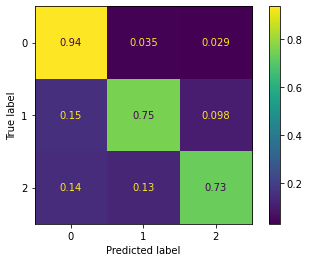

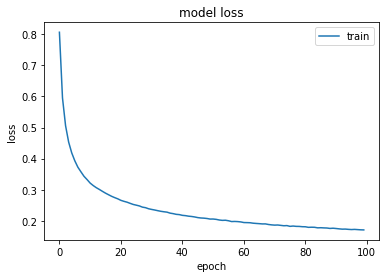

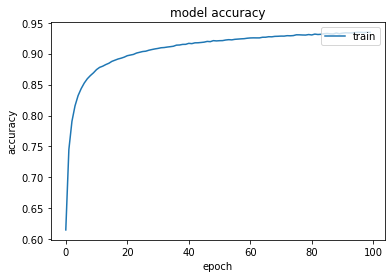

Epoch 1/100
8398/8398 [==============================] - 28s 3ms/step - loss: 0.8133 - accuracy: 0.6107 - val_loss: 0.7666 - val_accuracy: 0.6279
Epoch 2/100
8398/8398 [==============================] - 28s 3ms/step - loss: 0.6060 - accuracy: 0.7404 - val_loss: 0.7409 - val_accuracy: 0.6923
Epoch 3/100
8398/8398 [==============================] - 28s 3ms/step - loss: 0.5119 - accuracy: 0.7875 - val_loss: 0.7308 - val_accuracy: 0.7336
Epoch 4/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.4613 - accuracy: 0.8129 - val_loss: 0.6833 - val_accuracy: 0.7311
Epoch 5/100
8398/8398 [==============================] - 28s 3ms/step - loss: 0.4253 - accuracy: 0.8297 - val_loss: 0.6924 - val_accuracy: 0.7393
Epoch 6/100
8398/8398 [==============================] - 28s 3ms/step - loss: 0.4003 - accuracy: 0.8402 - val_loss: 0.7187 - val_accuracy: 0.7449
Epoch 7/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.3807 - accuracy: 0.8484 - val_loss: 0.7399 -

Epoch 57/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.2019 - accuracy: 0.9223 - val_loss: 1.0467 - val_accuracy: 0.7796
Epoch 58/100
8398/8398 [==============================] - 28s 3ms/step - loss: 0.2015 - accuracy: 0.9222 - val_loss: 1.0247 - val_accuracy: 0.7853
Epoch 59/100
8398/8398 [==============================] - 28s 3ms/step - loss: 0.1999 - accuracy: 0.9231 - val_loss: 1.0497 - val_accuracy: 0.7748
Epoch 60/100
8398/8398 [==============================] - 28s 3ms/step - loss: 0.2006 - accuracy: 0.9227 - val_loss: 1.0660 - val_accuracy: 0.7785
Epoch 61/100
8398/8398 [==============================] - 28s 3ms/step - loss: 0.1994 - accuracy: 0.9233 - val_loss: 1.1588 - val_accuracy: 0.7540
Epoch 62/100
8398/8398 [==============================] - 28s 3ms/step - loss: 0.1983 - accuracy: 0.9229 - val_loss: 1.0731 - val_accuracy: 0.7746
Epoch 63/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1967 - accuracy: 0.9235 - val_loss: 1

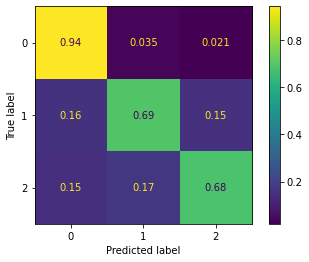

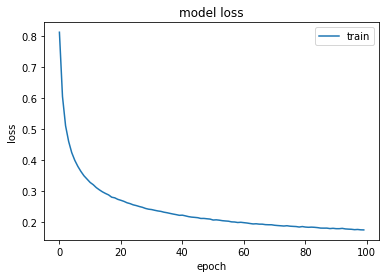

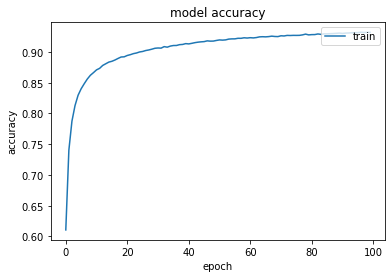

Epoch 1/100
8398/8398 [==============================] - 28s 3ms/step - loss: 0.8128 - accuracy: 0.6122 - val_loss: 0.6495 - val_accuracy: 0.7392
Epoch 2/100
8398/8398 [==============================] - 26s 3ms/step - loss: 0.5971 - accuracy: 0.7467 - val_loss: 0.5598 - val_accuracy: 0.7834
Epoch 3/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.5016 - accuracy: 0.7945 - val_loss: 0.5359 - val_accuracy: 0.7569
Epoch 4/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.4489 - accuracy: 0.8187 - val_loss: 0.5746 - val_accuracy: 0.7675
Epoch 5/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.4157 - accuracy: 0.8338 - val_loss: 0.5076 - val_accuracy: 0.7815
Epoch 6/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.3890 - accuracy: 0.8451 - val_loss: 0.5180 - val_accuracy: 0.8096
Epoch 7/100
8398/8398 [==============================] - 26s 3ms/step - loss: 0.3697 - accuracy: 0.8542 - val_loss: 0.5275 -

Epoch 57/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.2018 - accuracy: 0.9222 - val_loss: 0.6697 - val_accuracy: 0.8296
Epoch 58/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.2007 - accuracy: 0.9220 - val_loss: 0.6043 - val_accuracy: 0.8437
Epoch 59/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1995 - accuracy: 0.9225 - val_loss: 0.6606 - val_accuracy: 0.8305
Epoch 60/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1998 - accuracy: 0.9237 - val_loss: 0.6398 - val_accuracy: 0.8337
Epoch 61/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1969 - accuracy: 0.9241 - val_loss: 0.6950 - val_accuracy: 0.8183
Epoch 62/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1975 - accuracy: 0.9247 - val_loss: 0.6779 - val_accuracy: 0.8205
Epoch 63/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1957 - accuracy: 0.9246 - val_loss: 0

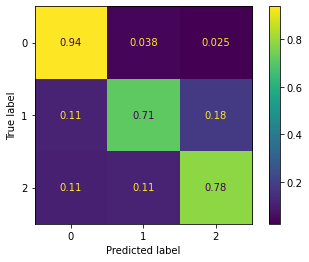

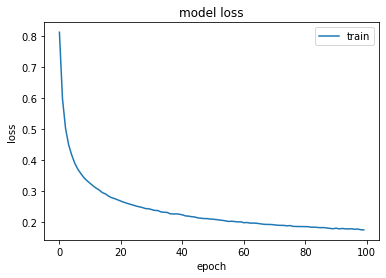

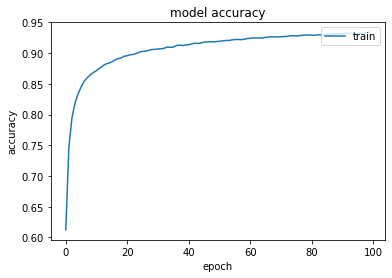

Epoch 1/100
8398/8398 [==============================] - 28s 3ms/step - loss: 0.8092 - accuracy: 0.6157 - val_loss: 0.7467 - val_accuracy: 0.6877
Epoch 2/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.5906 - accuracy: 0.7471 - val_loss: 0.6560 - val_accuracy: 0.7686
Epoch 3/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.5029 - accuracy: 0.7934 - val_loss: 0.6478 - val_accuracy: 0.8005
Epoch 4/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.4511 - accuracy: 0.8174 - val_loss: 0.5897 - val_accuracy: 0.8300
Epoch 5/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.4177 - accuracy: 0.8324 - val_loss: 0.6431 - val_accuracy: 0.8203
Epoch 6/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.3928 - accuracy: 0.8438 - val_loss: 0.6092 - val_accuracy: 0.8437
Epoch 7/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.3739 - accuracy: 0.8511 - val_loss: 0.6285 -

Epoch 57/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.2003 - accuracy: 0.9226 - val_loss: 1.2106 - val_accuracy: 0.8206
Epoch 58/100
8398/8398 [==============================] - 28s 3ms/step - loss: 0.1993 - accuracy: 0.9232 - val_loss: 1.2348 - val_accuracy: 0.8152
Epoch 59/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1983 - accuracy: 0.9237 - val_loss: 1.2618 - val_accuracy: 0.8101
Epoch 60/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1979 - accuracy: 0.9238 - val_loss: 1.2968 - val_accuracy: 0.8010
Epoch 61/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1955 - accuracy: 0.9245 - val_loss: 1.2252 - val_accuracy: 0.8180
Epoch 62/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1967 - accuracy: 0.9242 - val_loss: 1.2823 - val_accuracy: 0.7935
Epoch 63/100
8398/8398 [==============================] - 27s 3ms/step - loss: 0.1949 - accuracy: 0.9254 - val_loss: 1

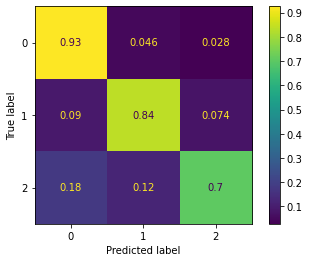

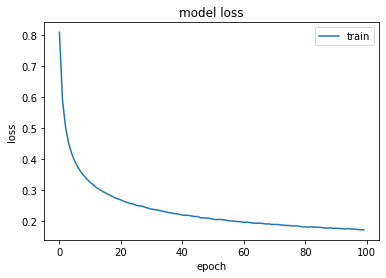

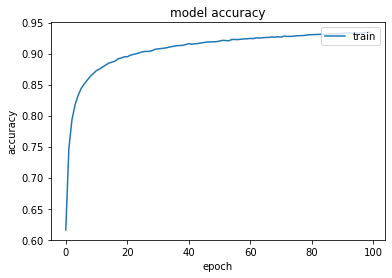

In [7]:
for i in range(10):
    X_test=empty
    X_train=empty
    y_test=empty
    y_train=empty
    y_test_list=[]
    
    for j in range(325):
        X_temp_test=X.iloc[Count_2*j+Count_1*i:Count_2*j+Count_1*(i+1)]
        X_test=pd.concat([X_test,X_temp_test])
        X_temp_train=X.iloc[Count_2*j+Count_1:Count_2*(j+1)]
        X_train=pd.concat([X_train,X_temp_train])
        
        y_temp_test=y.iloc[Count_2*j+Count_1*i:Count_2*j+Count_1*(i+1)]
        y_test=pd.concat([y_test,y_temp_test])
        y_temp_train=y.iloc[Count_2*j+Count_1:Count_2*(j+1)]
        y_train=pd.concat([y_train,y_temp_train])
        
    
#     print('SMOTE 적용 전 Train 레이블 값 분포: \n', y_train.value_counts())
#     print('SMOTE 적용 전 Test 레이블 값 분포: \n', y_test.value_counts())
    
    # SMOTE 적용
    smote = SMOTE(random_state=0)
    X_train, y_train = smote.fit_resample(X_train,y_train)
    X_test,y_test = smote.fit_resample(X_test,y_test)
#     print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_test.shape, y_test.shape)
#     print('SMOTE 적용 후 Train 레이블 값 분포: \n', y_train.value_counts())
#     print('SMOTE 적용 후 Test 레이블 값 분포: \n', y_test.value_counts())
    
    # 원핫인코딩
    # 예시 : 1 , 2 -> (1,0) , (0,1)
    y_train=pd.get_dummies(y_train[0])
    y_test=pd.get_dummies(y_test[0])
    
    if i==0:
        history=model0.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=18)
        predicted=model0.predict(X_test)
        results = model0.evaluate(X_test, y_test, batch_size=18)
        print("[{}]Accuracy : {}".format(i,results[1]))   

        
    if i==1:
        history=model1.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=18)
        predicted=model1.predict(X_test)
        results = model1.evaluate(X_test, y_test, batch_size=18)
        print("[{}]Accuracy : {}".format(i,results[1]))   

    if i==2:
        history=model2.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=18)
        predicted=model2.predict(X_test)
        results = model2.evaluate(X_test, y_test, batch_size=18)
        print("[{}]Accuracy : {}".format(i,results[1]))   
    
    if i==3:
        history=model3.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=18)
        predicted=model3.predict(X_test)
        results = model3.evaluate(X_test, y_test, batch_size=18)
        print("[{}]Accuracy : {}".format(i,results[1]))   
    
    if i==4:
        history=model4.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=18)
        predicted=model4.predict(X_test)
        results = model4.evaluate(X_test, y_test, batch_size=18)
        print("[{}]Accuracy : {}".format(i,results[1]))   
    
    if i==5:
        history=model5.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=18)
        predicted=model5.predict(X_test)
        results = model5.evaluate(X_test, y_test, batch_size=18)
        print("[{}]Accuracy : {}".format(i,results[1]))   
    
    if i==6:
        history=model6.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=18)
        predicted=model6.predict(X_test)
        results = model6.evaluate(X_test, y_test, batch_size=18)
        print("[{}]Accuracy : {}".format(i,results[1]))   
    
    if i==7:
        history=model7.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=18)
        predicted=model7.predict(X_test)
        results = model7.evaluate(X_test, y_test, batch_size=18)
        print("[{}]Accuracy : {}".format(i,results[1]))   
    
    if i==8:
        history=model8.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=18)
        predicted=model8.predict(X_test)
        results = model8.evaluate(X_test, y_test, batch_size=18)
        print("[{}]Accuracy : {}".format(i,results[1]))   
    
    if i==9:
        history=model9.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=18)
        predicted=model9.predict(X_test)
        results = model9.evaluate(X_test, y_test, batch_size=18)
        print("[{}]Accuracy : {}".format(i,results[1]))
    
    predicted=pd.DataFrame(predicted)
    predicted=predicted.idxmax(axis=1)
    y_test=y_test.idxmax(axis=1)
    
#     print("predicted",predicted)
#     print("y_test",y_test)
    
    #f1score
    f1 = f1_score(y_test,predicted, average='weighted')
    print("[{}]F1score : {}".format(i,f1))
    #precision/recall
    p_rlist=sk(y_test,predicted,average='weighted')
    print("[{}]Precision : {}".format(i,p_rlist[0]))
    print("[{}]Recall : {}".format(i,p_rlist[1]))
    print()
     #결과 배열에 넣기
    Result[i][0]=results[1]
    Result[i][1]=f1
    Result[i][2]=p_rlist[0]
    Result[i][3]=p_rlist[1]
    del results
    del f1
    del p_rlist
    
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    confusion_matrix(y_test, predicted)

    cm = confusion_matrix(y_test, predicted, labels=[0,1,2],normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
    disp.plot()
    filename=("ConfusionMatrix_"+str(i))
    plt.savefig(filename+".png")
    plt.show()
    
    LossResult[i]=history.history['loss']
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper right')
    filename=("LossGraph_"+str(i))
    plt.savefig(filename+".png")
    plt.show()
    
    AccuracyResult[i]=history.history['accuracy']
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper right')
    filename=("AccuracyGraph_"+str(i))
    plt.savefig(filename+".png")
    plt.show()
    
    del filename

In [8]:
Result_df=pd.DataFrame(Result,columns=['Accuracy','F1-Score','Precision','Recall'])
Result_df

,Accuracy,F1-Score,Precision,Recall
0,0.437647,0.404517,0.451737,0.437520
1,0.855067,0.854978,0.856383,0.855195
2,0.826138,0.825848,0.827624,0.826138
3,0.824761,0.823680,0.825559,0.824639
4,0.858017,0.857404,0.858403,0.858017
5,0.782130,0.778092,0.788074,0.782130
6,0.805341,0.803416,0.811621,0.805458
7,0.772709,0.768145,0.775217,0.772533
8,0.810296,0.807543,0.810882,0.810237
9,0.821036,0.818894,0.827347,0.821036


In [9]:
print("Average of Accuracy {}".format(Result_df['Accuracy'].mean()))
print("Average of F1-Score {}".format(Result_df['F1-Score'].mean()))
print("Average of Precision {}".format(Result_df['Precision'].mean()))
print("Average of Recall {}".format(Result_df['Recall'].mean()))

Average of Accuracy 0.7793141335248948
Average of F1-Score 0.7742518146256678
Average of Precision 0.7832845246627755
Average of Recall 0.7792902764678777


In [10]:
Matrix=pd.DataFrame(Result_df['Accuracy'],columns=['Accuracy'])
Matrix['Accuracy']=Result_df['Accuracy']
A=[Result_df['Accuracy'].mean(),Result_df['F1-Score'].mean(),Result_df['Precision'].mean(),Result_df['Recall'].mean()]
A=pd.DataFrame(A,columns=['Accuracy'])
Matrix=pd.concat([Matrix,A])
Matrix=Matrix.transpose()
Matrix.to_excel('./PFMatrix2.xlsx')

In [25]:
AverageLossResult=[0 for j in range(100)]
AverageAccuracyResult=[0 for j in range(100)]

for i in range(10):
    for j in range(100):
#         print(i,j)
        AverageLossResult[j]=AverageLossResult[j]+LossResult[i][j]
        AverageAccuracyResult[j]=AverageAccuracyResult[j]+AccuracyResult[i][j]
for k in range(100):
    AverageLossResult[k]=AverageLossResult[k]/10
    AverageAccuracyResult[k]=AverageAccuracyResult[k]/10

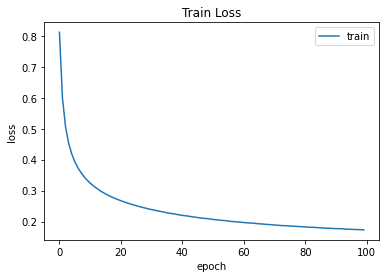

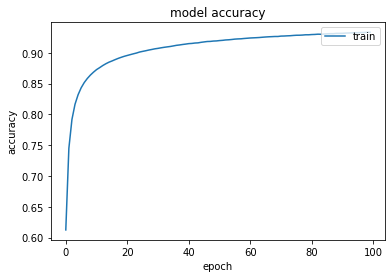

In [27]:
    plt.plot(AverageLossResult)
    plt.title('Train Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper right')
    filename=("LossGraph")
    plt.savefig(filename)
    plt.show()
    
    plt.plot(AverageAccuracyResult)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper right')
    filename=("AccuracyGraph")
    plt.savefig(filename+".png")
    plt.show()